In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/DATASET_SPLITTED.zip" -d "/content/kidney_dataset"

In [2]:
import pandas as pd
import numpy as np
import cv2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            classification_report, accuracy_score
import random

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout,\
                         Flatten, Dense, BatchNormalization

from keras.applications import VGG16
from keras.applications import ResNet50

import matplotlib.pyplot as plt
import seaborn as sns

from imutils import paths

import os

In [3]:
OUTPUT_DIR = '/content/kidney_dataset/OUTPUT_DIR'
classes = ['Normal','Cyst','Stone','Tumor']

In [4]:
imgPaths = list(paths.list_images(OUTPUT_DIR))
random.shuffle(imgPaths)

In [5]:
x_train = np.load('/content/drive/MyDrive/x_train.npy', mmap_mode='r')  # ленивая загрузка
y_train = np.load('/content/kidney_dataset/OUTPUT_DIR/y_train.npy', mmap_mode='r')  # если метки большие
x_test = np.load('/content/drive/MyDrive/x_test.npy', mmap_mode='r')
y_test = np.load('/content/kidney_dataset/OUTPUT_DIR/y_test.npy', mmap_mode='r')

In [13]:
x_train = x_train[:1000]
y_train = y_train[:1000]
x_test = x_test[:500]
y_test = y_test[:500]

In [14]:
def batch_generator(X, y, batch_size=32):
    num_samples = len(X)
    while True:  # бесконечный цикл для Keras
        for i in range(0, num_samples, batch_size):
            X_batch = X[i:i + batch_size]  # memmap автоматически загрузит только этот кусок
            y_batch = y[i:i + batch_size]
            yield np.array(X_batch), np.array(y_batch)  # преобразуем в numpy (если нужно)

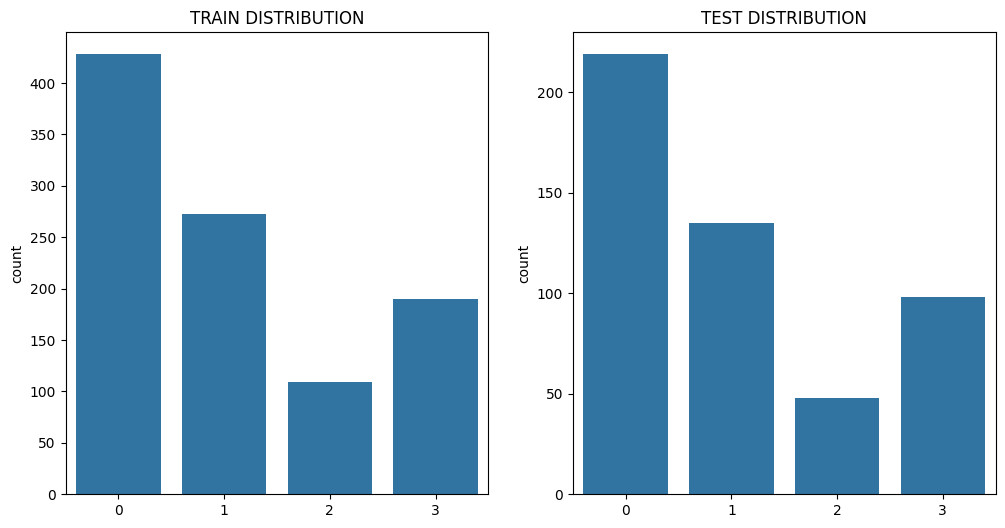

In [15]:
fig = plt.subplots(1, 2, figsize = (12, 6))

plt.subplot(121)
sns.countplot(x = y_train)
plt.title('TRAIN DISTRIBUTION')

plt.subplot(122)
sns.countplot(x = y_test)
plt.title('TEST DISTRIBUTION')
plt.show()

In [16]:
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

In [17]:
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test, model_name, batch_size=32):

    # Преобразуем class_weight в sample_weight для генератора
    sample_weights = np.array([class_weights[y] for y in y_train])

    # Создаем tf.data.Dataset вместо Python-генератора
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weights))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    test_dataset = test_dataset.batch(batch_size)

    # Callback для сохранения моделей
    save_dir = f'/content/drive/MyDrive/saved_models/{model_name}'
    os.makedirs(save_dir, exist_ok=True)
    checkpoint_path = os.path.join(save_dir, f'{model_name}_best.h5')
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        save_best_only=True,
        monitor='val_accuracy'
    )

    # Обучение с sample_weight вместо class_weight
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=25,
        callbacks=[checkpoint_cb]
    )

    # Сохранение финальной модели
    model.save(os.path.join(save_dir, f'{model_name}_final.h5'))

    # Предсказание (можно также чанковать для больших X_test)
    y_pred_probs = model.predict(x_test, batch_size=batch_size)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Plot Training History
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Confusion Matrix and Metrics
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=classes))
    print(f"{model_name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")

In [18]:
# CNN Model
def build_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.3415 - loss: 956.1531

32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.3441 - loss: 938.1656 - val_accuracy: 0.7520 - val_loss: 0.8906
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.7789 - loss: 0.6313

32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 684ms/step - accuracy: 0.7807 - loss: 0.6272 - val_accuracy: 0.9400 - val_loss: 0.1726
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9778 - loss: 0.0811

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 659ms/step - accuracy: 0.9777 - loss: 0.0814 - val_accuracy: 0.9580 - val_loss: 0.1057
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9793 - loss: 0.0521

32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 755ms/step - accuracy: 0.9794 - loss: 0.0521 - val_accuracy: 0.9640 - val_loss: 0.1078
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9989 - loss: 0.0065

32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 707ms/step - accuracy: 0.9988 - loss: 0.0066 - val_accuracy: 0.9700 - val_loss: 0.1313
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step - accuracy: 0.9969 - loss: 0.0104 - val_accuracy: 0.9540 - val_loss: 0.1624
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 267ms/step - accuracy: 0.9980 - loss: 0.0045 - val_accuracy: 0.9620 - val_loss: 0.1579
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 276ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9640 - val_loss: 0.1435
Epoch 9/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.9971 - loss: 0.0055 - val_accuracy: 0.9700 - val_loss: 0.1427
Epoch 10/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - accuracy: 0.9996 - loss: 0.0062 - val_accuracy: 0.9620 - val_loss: 0.1736
Epoch 11/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.9958 - loss: 0.0151 - val_accuracy: 0.9440 - val_loss: 0.2282
Epoch 12/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - accuracy: 0.9902 - loss: 0.0274 - val_accuracy: 0.9620 -

32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 915ms/step - accuracy: 0.9933 - loss: 0.0285 - val_accuracy: 0.9740 - val_loss: 0.1142
Epoch 16/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.9968 - loss: 0.0084 - val_accuracy: 0.9720 - val_loss: 0.1444
Epoch 17/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - accuracy: 1.0000 - loss: 4.1900e-04 - val_accuracy: 0.9700 - val_loss: 0.1622
Epoch 18/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.9988 - loss: 0.0035 - val_accuracy: 0.9700 - val_loss: 0.1719
Epoch 19/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 1.0000 - loss: 2.3169e-04 - val_accuracy: 0.9720 - val_loss: 0.1654
Epoch 20/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 271ms/step - accuracy: 0.9996 - loss: 0.0030 - val_accuracy: 0.9720 - val_loss: 0.1782
Epoch 21/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.9988 - loss: 0.0095 - val_accuracy: 0.9700 - val_loss: 0.1777
Epoch 22/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 271ms/step - accuracy: 1.0000 - loss: 6.3670e-04 - val_ac

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


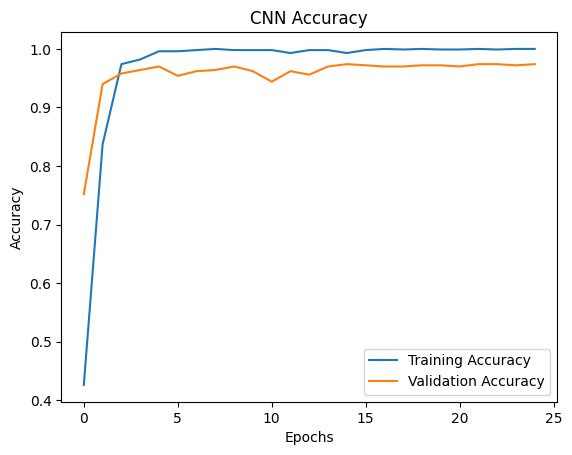

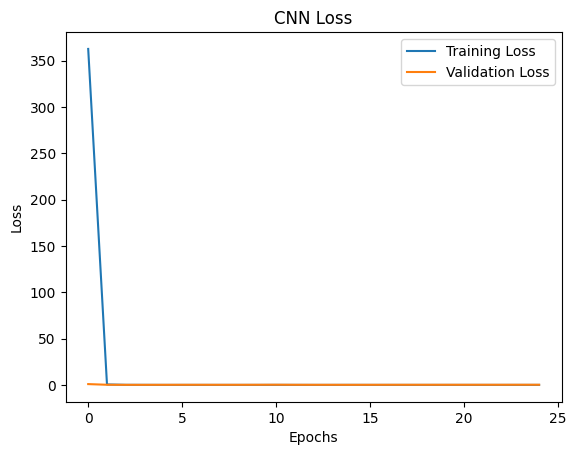

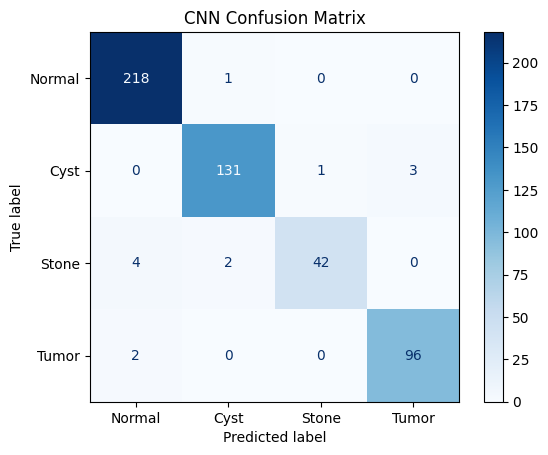

CNN Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98       219
        Cyst       0.98      0.97      0.97       135
       Stone       0.98      0.88      0.92        48
       Tumor       0.97      0.98      0.97        98

    accuracy                           0.97       500
   macro avg       0.97      0.96      0.96       500
weighted avg       0.97      0.97      0.97       500

CNN Accuracy: 0.9740


In [19]:
cnn = build_cnn()
train_and_evaluate_model(cnn, x_train, y_train, x_test, y_test, "CNN")

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3718 - loss: 113.6881   

32/32 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - accuracy: 0.3732 - loss: 113.3877 - val_accuracy: 0.7680 - val_loss: 10.6654
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.6000 - loss: 36.0798

32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6000 - loss: 35.9844 - val_accuracy: 0.8420 - val_loss: 4.7853
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6140 - loss: 20.4392 - val_accuracy: 0.7620 - val_loss: 3.5984
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5653 - loss: 11.4069 - val_accuracy: 0.7440 - val_loss: 1.5721
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5213 - loss: 6.2917 - val_accuracy: 0.4620 - val_loss: 0.9452
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3925 - loss: 6.0313 - val_accuracy: 0.4460 - val_loss: 2.0180
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5575 - loss: 5.0305 - val_accuracy: 0.7100 - val_loss: 1.2474
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6346 - loss: 3.0747 - val_accuracy: 0.7100 - val_loss: 1.2898
Epoch 9/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6853 - loss: 2.7783 - val_accuracy: 0.7020 - val_loss: 1.3488


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 861ms/step


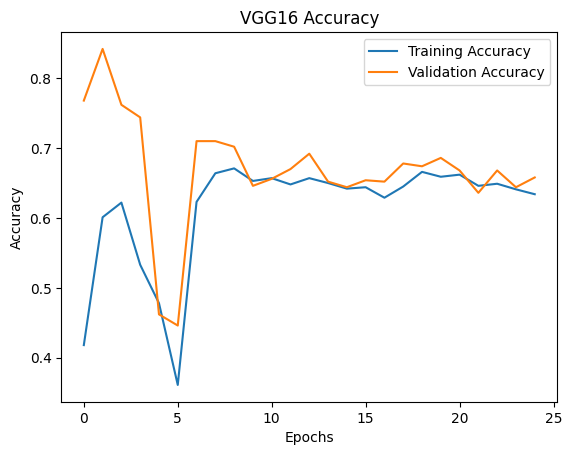

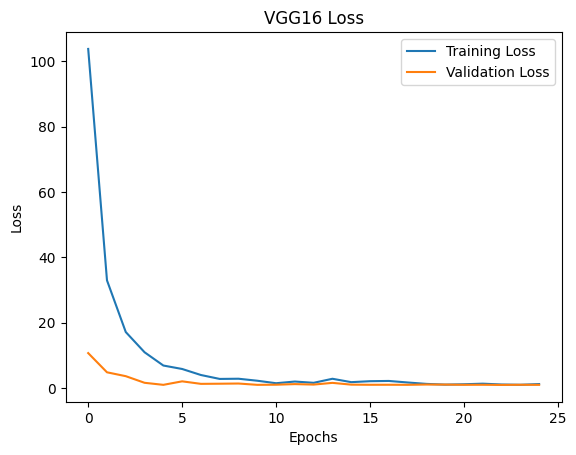

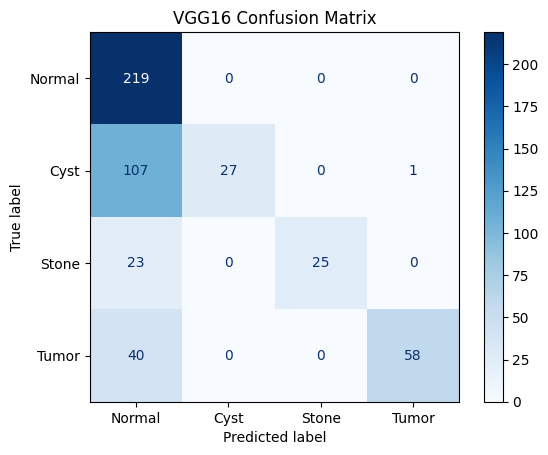

VGG16 Classification Report:
              precision    recall  f1-score   support

      Normal       0.56      1.00      0.72       219
        Cyst       1.00      0.20      0.33       135
       Stone       1.00      0.52      0.68        48
       Tumor       0.98      0.59      0.74        98

    accuracy                           0.66       500
   macro avg       0.89      0.58      0.62       500
weighted avg       0.81      0.66      0.62       500

VGG16 Accuracy: 0.6580


In [20]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
for layer in vgg16_base.layers:
    layer.trainable = False

vgg16_model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

train_and_evaluate_model(vgg16_model, x_train, y_train, x_test, y_test, "VGG16")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.3271 - loss: 127.4618

32/32 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.3288 - loss: 127.1187 - val_accuracy: 0.6400 - val_loss: 18.4237
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.5250 - loss: 41.8339

32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 937ms/step - accuracy: 0.5245 - loss: 41.5948 - val_accuracy: 0.7800 - val_loss: 3.8078
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 723ms/step - accuracy: 0.5155 - loss: 20.4114 - val_accuracy: 0.7460 - val_loss: 1.5667
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 566ms/step - accuracy: 0.5497 - loss: 8.0647 - val_accuracy: 0.6720 - val_loss: 1.1690
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 585ms/step - accuracy: 0.6158 - loss: 5.0068 - val_accuracy: 0.6540 - val_loss: 1.0739
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 572ms/step - accuracy: 0.5849 - loss: 3.8789 - val_accuracy: 0.6380 - val_loss: 1.1189
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 558ms/step - accuracy: 0.5952 - loss: 3.3231 - val_accuracy: 0.6360 - val_loss: 1.2822
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 558ms/step - accuracy: 0.6019 - loss: 1.8082 - val_accuracy: 0.6320 - val_loss: 1.4961
Epoch 9/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 561ms/step - accuracy: 0.6107 - loss: 2.9322 - val_accuracy: 0.6

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 596ms/step


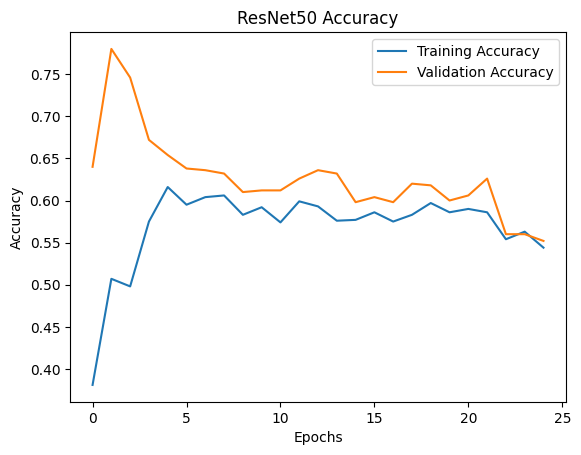

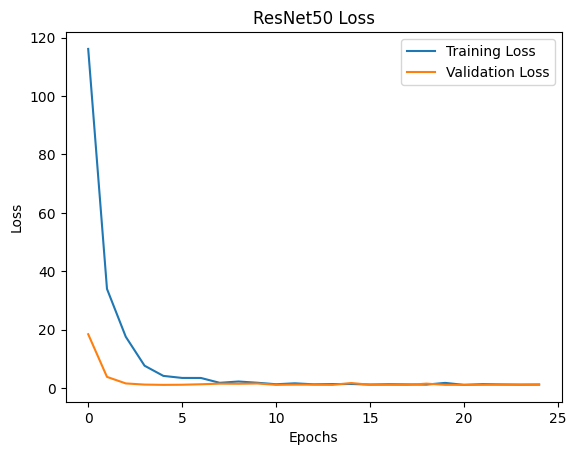

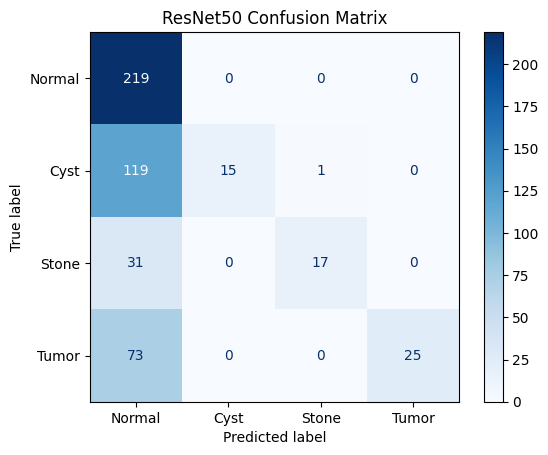

ResNet50 Classification Report:
              precision    recall  f1-score   support

      Normal       0.50      1.00      0.66       219
        Cyst       1.00      0.11      0.20       135
       Stone       0.94      0.35      0.52        48
       Tumor       1.00      0.26      0.41        98

    accuracy                           0.55       500
   macro avg       0.86      0.43      0.45       500
weighted avg       0.77      0.55      0.47       500

ResNet50 Accuracy: 0.5520


In [21]:
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
for layer in resnet50_base.layers:
    layer.trainable = False

resnet50_model = Sequential([
    resnet50_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])
resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

train_and_evaluate_model(resnet50_model, x_train, y_train, x_test, y_test, "ResNet50")